# Hypothesis Testing: UCI Iris Data Set
### Kevin Maher
### <span style="color:blue">Vettejeep365@gmail.com</span>

Imports needed for the script.  Uses Python 2.7.13, pandas 0.19.2, scipy 0.18.1, matplotlib 2.0.0, statsmodels 0.6.1.

In [6]:
%matplotlib inline

import pandas as pd
from scipy import stats
from statsmodels.stats.multicomp import MultiComparison
import statsmodels.sandbox.stats.multicomp as mc
import statsmodels.stats.weightstats as ws
import matplotlib.pyplot as plt

Import the data, please see the citation below.

In [7]:
df = pd.read_csv('iris.data.csv')
print df.head()

   sepal_length  sepal_width  petal_length  petal_width        class
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa


Select one field, 'sepal width' for analysis.  Is there a significant different in sepal width for the three species of Iris plants in the data?  This is what we will answer below.

In [8]:
field = 'sepal_width'
setosa = df[field].loc[df['class'] == 'Iris-setosa']
versicolor = df[field].loc[df['class'] == 'Iris-versicolor']
virginica = df[field].loc[df['class'] == 'Iris-virginica']

Print summary statistics.  Gives mean and standard deviation amongst others.

In [9]:
print 'Setosa summary statistics:'
print setosa.describe()
print '\nVersicolor summary statistics:'
print versicolor.describe()
print '\nVirginica summary statistics:'
print virginica.describe()

Setosa summary statistics:
count    50.000000
mean      3.418000
std       0.381024
min       2.300000
25%       3.125000
50%       3.400000
75%       3.675000
max       4.400000
Name: sepal_width, dtype: float64

Versicolor summary statistics:
count    50.000000
mean      2.770000
std       0.313798
min       2.000000
25%       2.525000
50%       2.800000
75%       3.000000
max       3.400000
Name: sepal_width, dtype: float64

Virginica summary statistics:
count    50.000000
mean      2.974000
std       0.322497
min       2.200000
25%       2.800000
50%       3.000000
75%       3.175000
max       3.800000
Name: sepal_width, dtype: float64


Is the data normally distributed?  Python uses D'Agostino and Pearson's test.  All of the p-values are well above the usual threshold of 0.05, so the data may be considered to be normally distributed.

In [10]:
s, p = stats.normaltest(setosa)
print 'Normality test for Setosa, p-value: %.4f' % p

s, p = stats.normaltest(versicolor)
print 'Normality test for Versicolor, p-value: %.4f' % p

s, p = stats.normaltest(virginica)
print 'Normality test for Virginica, p-value: %.4f' % p

Normality test for Setosa, p-value: 0.3889
Normality test for Versicolor, p-value: 0.4841
Normality test for Virginica, p-value: 0.2771


Check for equal variances.  We will use Bartlett's test since the data passed a normality test above.  Levene's test could be used if the data was not normally distributed.  The p-value is above 0.33, far above 0.05, so the data can be considered to have equal variances.  The test automatically corrects for having three categories.

In [11]:
W, p = stats.bartlett(setosa, versicolor, virginica)
print 'Bartlett test for equal variances, p-value: %.4f' % p

Bartlett test for equal variances, p-value: 0.3302


Let's look at a box plot of the data.  The notch is the confidence interval around the median.

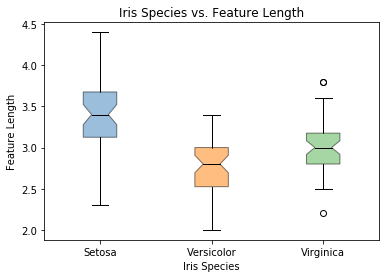

In [12]:
colors = ('#377eb8', '#ff7f00', '#4daf4a')
box_plot_data = [setosa, versicolor, virginica]

# box plots - the notch is the confidence interval around the median
bplot = plt.boxplot(box_plot_data,
                    notch=True,  # notch shape
                    vert=True,  # vertical box alignment
                    patch_artist=True,  # fill with color
                    labels=['Setosa', 'Versicolor', 'Virginica'])  # will be used to label x-ticks
for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        patch._alpha = 0.5
for line in bplot['medians']:
    line._color = 'k'

plt.xlabel("Iris Species")
plt.ylabel("Feature Length")
plt.title("Iris Species vs. Feature Length")
plt.show()

Since the data can be considered to be normally distributed and to have equal variances, we can perform a one-way ANOVA to determine if there is a significant difference in the mean value for sepal width between the Iris species.  The p-value of zero strongly indicates that at least one species has a significantly different sepal width.

In [13]:
F, p = stats.f_oneway(setosa, versicolor, virginica)
print 'P-value for ANOVA: %.4f' % p

P-value for ANOVA: 0.0000


Which species pairs are significantly different?  The Tukey post-hoc test can help us to determine this.  The Tukey test rejects the null hypothesis for all three groupings.  Hence, we can say that sepal width is significantly different for all three pairs of the three species.

In [14]:
mc_tukey = MultiComparison(df[field], df['class'])
result = mc_tukey.tukeyhsd()

print 'Tukey HSD Results'
print(result)
print(mc_tukey.groupsunique)

Tukey HSD Results
       Multiple Comparison of Means - Tukey HSD,FWER=0.05      
     group1          group2     meandiff  lower   upper  reject
---------------------------------------------------------------
  Iris-setosa   Iris-versicolor  -0.648  -0.8092 -0.4868  True 
  Iris-setosa    Iris-virginica  -0.444  -0.6052 -0.2828  True 
Iris-versicolor  Iris-virginica  0.204    0.0428  0.3652  True 
---------------------------------------------------------------
['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


We can also do this with multiple z-tests by applying a correction to the p-values for multiple tests.  The correction makes up for the loss of statistical power caused by performing multiple tests.  Again, all three pairs can be judged to be significantly different because the corrected p-values are well below 0.05.  Z-tests are preferred over t-tests here because of the large sample size (50 which is over the recomended cutoff of 30 for a t-test).

In [15]:
tstat, p_set_ver = ws.ztest(setosa, versicolor)
tstat, p_set_vir = ws.ztest(setosa, virginica)
tstat, p_ver_vir = ws.ztest(versicolor, virginica)
rej, pvc, aS, aB = mc.multipletests((p_set_ver, p_set_vir, p_ver_vir))
print '\nCorrected p-values for doing multiple z-tests:'
print 'Setosa-Versicolor; Setosa-Virginica; Versicolor-Virginica'
print pvc


Corrected p-values for doing multiple z-tests:
Setosa-Versicolor; Setosa-Virginica; Versicolor-Virginica
[  0.00000000e+00   6.37452313e-10   1.34705938e-03]


We can also demonstrate some more plotting.  First, a normality plot for the sepal width of the Iris Setosa species.  Interestingly, the data is qualtized by the resolution of the original measurement, but still passed statistical tests for normality above.

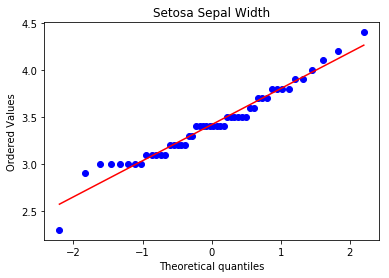

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
stats.probplot(setosa, plot=ax)
ax.set_title("Setosa Sepal Width")
plt.show()

We can also make a CDF (cumulative distribution function) plot for all three Iris species.  Python uses a hollow histogram for this type of plot, not perhaps as neat as a plot from Minitab or a similar program, but it still works.

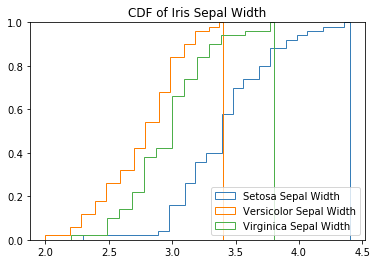

In [17]:
figure = plt.figure()
plt.hist(setosa, len(setosa), normed=1, histtype='step', cumulative=True, color=colors[0],
         label='Setosa Sepal Width')
plt.hist(versicolor, len(versicolor), normed=1, histtype='step', cumulative=True, color=colors[1],
         label='Versicolor Sepal Width')
plt.hist(virginica, len(virginica), normed=1, histtype='step', cumulative=True, color=colors[2],
         label='Virginica Sepal Width')
plt.ylim((0, 1))
plt.legend(loc=4)
plt.title('CDF of Iris Sepal Width')
plt.show()

Citation:
Iris Data Set (1998). UCI Machine Learning Repository.  Retrieved from: 

https://archive.ics.uci.edu/ml/datasets/iris. 